
# Hydra-Gro: Predicting Kit Sales from Ad Spend with Linear Regression 💧🌱

This Colab-ready notebook walks through a **complete Linear Regression workflow** using a fictional but realistic business story from **Hydra-Gro**, a startup selling smart indoor gardening kits.

We'll help **Alex, the Operations Manager**, answer a high-pressure question:

> **“If we spend \$10,000 on ads tomorrow, how many kits should we have ready in the warehouse?”**

We’ll follow this structure:

1. **Installation**
2. **Dataset Preparation** (create a synthetic but realistic dataset from the story)
3. **Descriptive Analysis & Visualization**
4. **Train–Test Split**
5. **Model Building (Linear Regression)**
6. **Model Evaluation**
7. **Business Interpretation & Black Friday Prediction**



## 1. Installation

In Colab, most libraries are already installed.  
We’ll still include an installation cell so this notebook is **self-contained** if run elsewhere.


In [14]:

# If you're running this outside Google Colab and missing packages, uncomment and run:
# !pip install -q numpy pandas matplotlib scikit-learn



## 2. Imports & Colab Setup

We’ll import the core libraries needed for:

- Data manipulation (**pandas**, **numpy**)
- Visualization (**matplotlib**)
- Machine learning (**scikit-learn**)


In [15]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make charts appear inline and set a basic style
%matplotlib inline

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



## 3. Dataset Preparation 📊

### 3.1. Business Assumptions from the Story

From Alex’s story at **Hydra-Gro**, we can infer a simple underlying relationship between:

- **X = Ad Spend (USD)** – what Alex can control  
- **Y = Kits Sold (Units)** – what Alex wants to predict  

The story gives us a (rough) linear model:

\[
\text{Kits Sold} \approx 30 + 0.15 \times \text{Ad Spend}
\]

- **Intercept (30)** → Even with \$0 ad spend, Hydra-Gro sells about **30 kits/day** via word-of-mouth.
- **Slope (0.15)** → For every additional **\$1** spent, they sell about **0.15 kits**  
  (i.e. **\$100 extra spend → ~15 extra kits**).

We’ll create a **synthetic dataset** that simulates:

- Around **1 year of daily data** (e.g. 365 days)
- Daily ad spend between **\$0 and \$5,000** on most days
- A few **“campaign” days** with higher spend (up to \$12,000)
- Random noise (good/bad days, tweets, weather, etc.)  
- Occasional **outliers** where sales are unusually high

This mimics the “swarm of bees” scatterplot Alex sees.



### 3.2. Quick Glance at the Data

Let’s look at **basic statistics** and ensure the numbers are reasonable.


In [17]:

data.describe()


,day,ad_spend,kits_sold,is_campaign_day
count,365.000000,365.000000,365.000000,365.000000
mean,183.000000,2586.173781,421.912329,0.021918
std,105.510663,1749.587807,265.423129,0.146616
min,1.000000,25.310000,0.000000,0.000000
25%,92.000000,1219.950000,215.000000,0.000000
50%,183.000000,2571.170000,414.000000,0.000000
75%,274.000000,3732.460000,586.000000,0.000000
max,365.000000,11203.290000,1800.000000,1.000000


In [16]:

# Parameters for synthetic data
n_days = 365

# Typical daily ad spend between 0 and 5000 USD
base_ad_spend = np.random.uniform(0, 5000, size=n_days)

# Randomly choose a few high-intensity campaign days (like Black Friday promotions)
n_campaign_days = 8
campaign_indices = np.random.choice(range(n_days), size=n_campaign_days, replace=False)
base_ad_spend[campaign_indices] = np.random.uniform(6000, 12000, size=n_campaign_days)

# True underlying relationship from the story
true_intercept = 30       # base sales even with no ads
true_slope = 0.15         # extra kits per $1 of ad spend

# Random noise: some days better, some worse (roughly normal distribution)
noise = np.random.normal(loc=0, scale=40, size=n_days)  # scale controls spread

# Generate kits sold
kits_sold = true_intercept + true_slope * base_ad_spend + noise

# Ensure no negative sales (just in case noise pushes below zero)
kits_sold = np.clip(kits_sold, a_min=0, a_max=None)

# Mark whether a given day was a high-intensity campaign
is_campaign_day = np.zeros(n_days, dtype=int)
is_campaign_day[campaign_indices] = 1

# Build DataFrame
data = pd.DataFrame({
    "day": np.arange(1, n_days + 1),
    "ad_spend": np.round(base_ad_spend, 2),
    "kits_sold": np.round(kits_sold, 0).astype(int),
    "is_campaign_day": is_campaign_day
})

data.head()


,day,ad_spend,kits_sold,is_campaign_day
0,1,1872.70,280,0
1,2,4753.57,766,0
2,3,3659.97,627,0
3,4,2993.29,488,0
4,5,780.09,150,0



## 4. Descriptive Analysis & Visualization 📈

Before building any model, Alex should **explore the data** to understand:

- Typical levels of ad spend
- Typical kit sales
- Whether a **linear trend** between ad spend and sales is visible
- The presence of outliers (e.g., “celebrity tweet” days)



### 4.1. Distribution of Ad Spend and Kits Sold


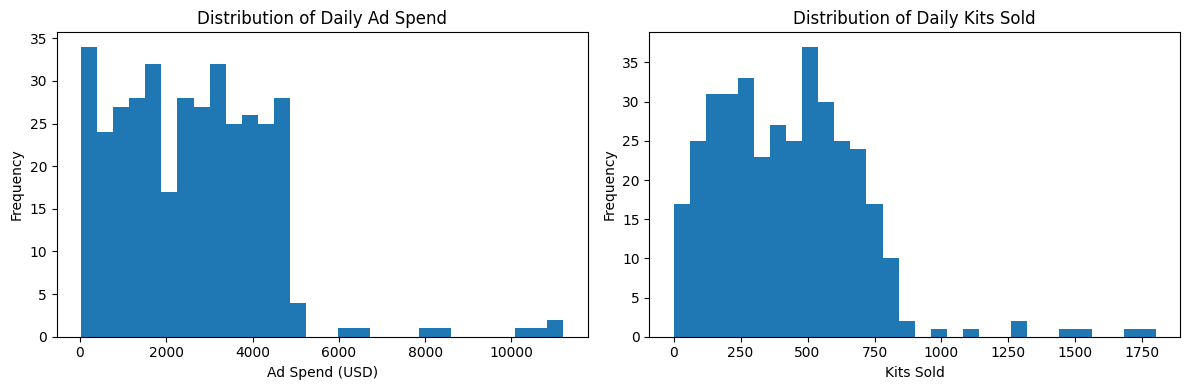

In [18]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(data["ad_spend"], bins=30)
axes[0].set_title("Distribution of Daily Ad Spend")
axes[0].set_xlabel("Ad Spend (USD)")
axes[0].set_ylabel("Frequency")

axes[1].hist(data["kits_sold"], bins=30)
axes[1].set_title("Distribution of Daily Kits Sold")
axes[1].set_xlabel("Kits Sold")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()



### 4.2. Scatter Plot: Ad Spend vs Kits Sold

This is the **scatter plot** Alex sees on his screen: each dot is a day.

- **X-axis:** Daily ad spend (USD)  
- **Y-axis:** Kits sold that day (units)


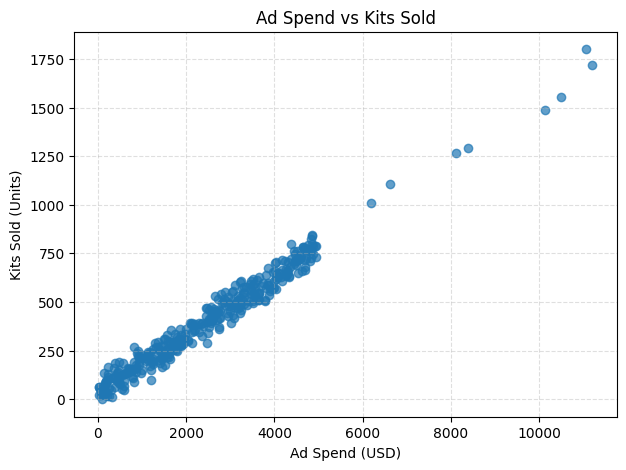

In [19]:

plt.figure(figsize=(7, 5))
plt.scatter(data["ad_spend"], data["kits_sold"], alpha=0.7)
plt.title("Ad Spend vs Kits Sold")
plt.xlabel("Ad Spend (USD)")
plt.ylabel("Kits Sold (Units)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()



You should notice:

- A general **upward trend** (more ad spend → more sales)
- Some **scatter/noise** around the trend line
- A few points that sit unusually high or low for a given ad spend (special events, bad days, etc.)

This is exactly the “swarm of bees” Alex observes.



## 5. Train–Test Split 🧪

To evaluate how well Linear Regression generalizes, we split our data into:

- **Training set** – data used to **fit** the model  
- **Test set** – data held back and used only to **evaluate** performance

We’ll predict **`kits_sold`** using **`ad_spend`** as the only feature.

> In a real business, Alex might add more features: weekday vs weekend, email campaigns, discounts, etc.  
> Here, we keep it simple and focused.


In [20]:

# Feature matrix (X) and target vector (y)
X = data[["ad_spend"]]  # must be 2D for scikit-learn
y = data["kits_sold"]   # 1D target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

X_train.shape, X_test.shape


((292, 1), (73, 1))


## 6. Model Building: Linear Regression 🧮

Now we let the computer **fit a straight line** through the cloud of points.

In mathematical terms, we are fitting:

\[
\hat{y} = \beta_0 + \beta_1 x
\]

Where:

- \(\hat{y}\) = predicted kits sold  
- \(x\) = ad spend  
- \(\beta_0\) = intercept (baseline daily sales)  
- \(\beta_1\) = slope (extra kits per \$1 spent)


In [21]:

# Initialize and train the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Extract learned parameters
learned_intercept = lin_reg.intercept_
learned_slope = lin_reg.coef_[0]

print(f"Learned intercept (β0): {learned_intercept:.2f} kits")
print(f"Learned slope (β1): {learned_slope:.4f} kits per $1 of ad spend")


Learned intercept (β0): 33.64 kits
Learned slope (β1): 0.1500 kits per $1 of ad spend



**Interpretation in Alex’s language:**

- **Intercept (β0)** – Approximate number of kits Hydra-Gro sells **even with \$0 ad spend**, thanks to word-of-mouth and organic traffic.
- **Slope (β1)** – For **every additional \$1** in ad spend, Hydra-Gro sells **β1 more kits** on average.  
  Multiply β1 by 100 to estimate **extra kits per \$100** in ad spend.

If we did a good job generating the dataset, β1 should be close to the true slope of **0.15** from the story, and β0 should be close to **30**.



## 7. Model Evaluation 📏

We’ll evaluate how well the model predicts on the **test set** using:

- **MAE (Mean Absolute Error)** – average absolute difference between predicted and actual sales
- **MSE (Mean Squared Error)** and **RMSE** – penalize larger errors more
- **R² (Coefficient of Determination)** – how much of the variance in `kits_sold` is explained by `ad_spend`


In [22]:

# Predictions on the test set
y_pred_test = lin_reg.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

print(f"Mean Absolute Error (MAE): {mae:.2f} kits")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} kits")
print(f"R-squared (R²): {r2:.3f}")


Mean Absolute Error (MAE): 33.04 kits
Mean Squared Error (MSE): 1915.01
Root Mean Squared Error (RMSE): 43.76 kits
R-squared (R²): 0.965



### 7.1. Visualizing Predictions vs Actuals

Let’s plot **predicted vs actual** values on the test set.

- Points close to the diagonal line indicate good predictions.


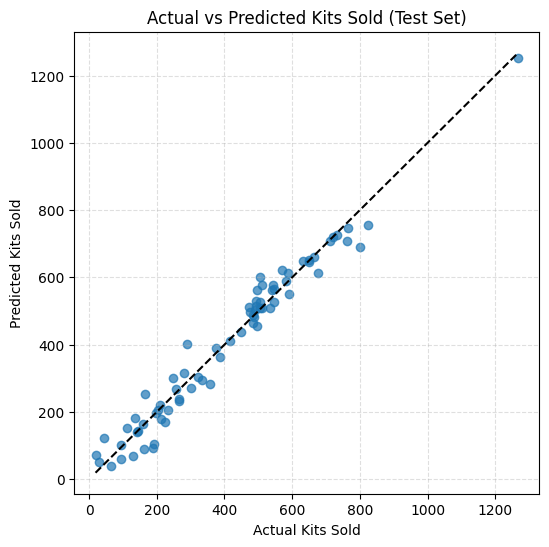

In [23]:

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--")
plt.xlabel("Actual Kits Sold")
plt.ylabel("Predicted Kits Sold")
plt.title("Actual vs Predicted Kits Sold (Test Set)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()



### 7.2. Residual Plot (Error Analysis)

Residuals = **Actual − Predicted**.  
Ideally, residuals should be centered around zero with no obvious pattern.


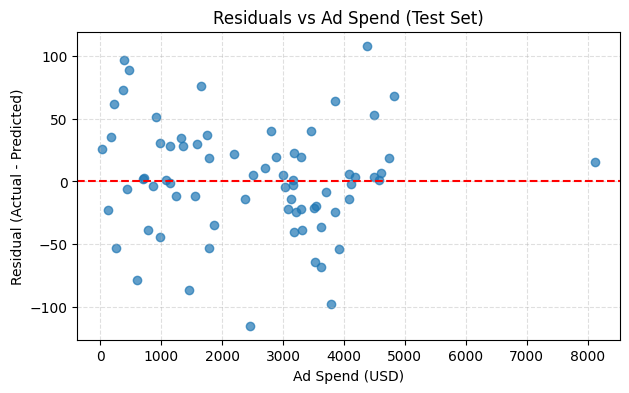

In [24]:

residuals = y_test - y_pred_test

plt.figure(figsize=(7, 4))
plt.scatter(X_test["ad_spend"], residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Ad Spend (USD)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Ad Spend (Test Set)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()



## 8. Business Interpretation & Black Friday Prediction 🎯

### 8.1. Using the Model Like Alex

Now we step into Alex’s shoes.

- Tomorrow’s **planned ad spend**: **\$10,000**
- Alex wants to know: **How many kits should the warehouse pack?**

We’ll plug \$10,000 into our trained Linear Regression model.


In [25]:

ad_spend_black_friday = 10_000  # USD

predicted_sales_black_friday = lin_reg.predict([[ad_spend_black_friday]])[0]

print(f"Predicted kits sold for ${ad_spend_black_friday:,}: {predicted_sales_black_friday:.0f} kits")


Predicted kits sold for $10,000: 1534 kits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



### 8.2. Comparing with the Story Outcome

In the story:

- The formula suggested:  
  \[
  \hat{y} = 30 + 0.15 \times 10{,}000 = 1{,}530 \text{ kits}
  \]
- Alex told the warehouse: **“Pack 1,550 units”** (adding a bit of buffer)
- Actual sales: **1,495 kits**

Let’s simulate the **“story outcome”** and compare it with our model’s prediction.


In [26]:

# Story-based "true" outcome for reference
story_formula_prediction = 30 + 0.15 * ad_spend_black_friday
story_actual_sales = 1495

print(f"Story formula prediction: {story_formula_prediction:.0f} kits")
print(f"Story actual sales (given): {story_actual_sales} kits")

# Compare our model to the story actual
model_error_vs_story = predicted_sales_black_friday - story_actual_sales
percent_error_vs_story = 100 * model_error_vs_story / story_actual_sales

print("\nModel vs Story Actual:")
print(f"Model prediction: {predicted_sales_black_friday:.0f} kits")
print(f"Difference (Model - Story Actual): {model_error_vs_story:.1f} kits")
print(f"Percent error vs story actual: {percent_error_vs_story:.2f}%")


Story formula prediction: 1530 kits
Story actual sales (given): 1495 kits

Model vs Story Actual:
Model prediction: 1534 kits
Difference (Model - Story Actual): 38.9 kits
Percent error vs story actual: 2.60%



### 8.3. Takeaways for Alex (and You)

- The model will **not be perfect**, but it gives a **data-driven estimate**.
- Instead of guessing 500 or 3,000 units, Alex can:

  1. Use the **learned linear relationship** between ad spend and sales.
  2. Get a **reasonable prediction** (e.g., around 1,500 kits).
  3. Add a **small operational buffer** (e.g., +2–5%) based on risk appetite.

- A **2–5% error** in such a volatile setting is incredibly powerful for decision-making.
- This is why **Linear Regression** remains one of the most useful tools in operations and marketing analytics.

---

### 🔁 Next Steps / Extensions

If you want to extend this notebook, you could:

- Add more features (day of week, discount amount, email campaigns, etc.)
- Try **Polynomial Regression** if you suspect diminishing returns on ad spend
- Compare Linear Regression with **Tree-Based Models** (Random Forest, Gradient Boosting)
- Build a **what-if dashboard** for Alex to explore different ad budgets interactively
